## Credit Risk Modeling Case Study  <br>
Submitted By: Paras Patel <br>
Date: December 4, 2019

### Table of Contents ###
<ul>
<li><a href="#Project Overview">Project Overview</a></li>
<li><a href="#Data Gathering">Data Gathering</a></li>
<li><a href="#Data Pre-Processing">Data Pre-Processing</a></li>
<li><a href="#Feature Selection">Feature Selection</a></li>
<li><a href="#LDA-SVM">Model 1 - Linear Discriminant Analysis / Support Vector Machine Classifier</a></li>
<li><a href="#Random Forest">Model 2 - Random Forest Classifier</a></li>
<li><a href="#Regression">Model 3 - Regression Model to Estimate Losses (Risk Assessment)</a></li>
<li><a href="#Final">Final Dataframe - Results</a></li>
</ul>

<a id='Project Overview'></a>
### Project Overview ###

Prosper Loan is a peer to peer marketplace that provides unsecured personal loans to interested borrowers and lenders looking to invest. Creditors can invest anywhere from 2,000 USD - 40,000 USD. The goal of this analysis is to assess and quantify risk of on-going and future loans.

To achieve this, a supervised machine learning algorithm was used to classify the outcome of a loan (successfully completed or defaulted). 2 methods were considered: 1) Using a wrapper (Linear Discriminant Analysis) for feature reduction and overlaying an SVM classifier and 2) A Random Forest Tree classifier.

The predictions of the classifier are then queried for loans labeled as 'Defaulted' (high-risk) and fitted to a regression model to estimate potential losses associated with the loan. 

To summarize, models in this study will answer the following questions:

1.  **Which borrowers/customers at Prosper Loan are currently high risk, based on individual background/financial features?** <br>
2.  **What are the potential losses on future loans based on borrower's background/financial features?** <br>
3. **What are the top predictor variables that influence loan outcome and how significant are they?** <br>

<a id='Data Gathering'></a>
### Data Gathering ###

In [1]:
# Import Libraries for Data Wrangling And Visualizations
import pandas as pd
import numpy as np
from time import time

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb

import warnings
warnings.filterwarnings('ignore')

42 columns removed as non discrimating features.

In [2]:
path = "/Users/paraspatel/Desktop/Udacity/Data Analysis With R/Project/prosperLoanData1.csv"
df = pd.read_csv(path)
df_copy = df.copy()
df.head(5)

,ListingKey,Term,LoanStatus,BorrowerAPR,LenderYield,EmploymentStatus,IsBorrowerHomeowner,CreditScoreRangeLower,CurrentCreditLines,OpenCreditLines,...,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,LoanFirstDefaultedCycleNumber,LoanOriginalAmount,MonthlyLoanPayment,LP_CustomerPayments,LP_CustomerPrincipalPayments,LP_GrossPrincipalLoss
0,1021339766868145413AB3B,36,Completed,0.16516,0.1380,Self-employed,True,640.0,5.0,4.0,...,NaN,NaN,NaN,NaN,NaN,9425,330.43,11396.14,9425.00,0.0
1,10273602499503308B223C1,36,Current,0.12016,0.0820,Employed,False,680.0,14.0,14.0,...,NaN,NaN,NaN,NaN,NaN,10000,318.93,0.00,0.00,0.0
2,0EE9337825851032864889A,36,Completed,0.28269,0.2400,Not available,False,480.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3001,123.32,4186.63,3001.00,0.0
3,0EF5356002482715299901A,36,Current,0.12528,0.0874,Employed,True,800.0,5.0,5.0,...,NaN,NaN,NaN,NaN,NaN,10000,321.45,5143.20,4091.09,0.0
4,0F023589499656230C5E3E2,36,Current,0.24614,0.1985,Employed,True,680.0,19.0,19.0,...,0.0,0.0,11000.0,9947.9,NaN,15000,563.97,2819.85,1563.22,0.0


<a id='Data Pre-Processing'></a>
### Data Pre-Processing

In [3]:
# Missing Value Ratio. If feature consists of 80% or more missing values (NaN), then remove feature 
original_columns = df.shape[1]
dropped_columns=[]
for col in df.columns:
    if df[col].isna().sum() / df[col].shape[0] > 0.80:
        df.drop(col,inplace=True,axis=1)
print('Number of columns removed =', original_columns-df.shape[1])
print('Total Columns =',df.shape[1])

Number of columns removed = 8
Total Columns = 31


In [4]:
#Drop NaN values & Duplicates
df.dropna(inplace=True)
df = df.drop_duplicates(keep=False)
df.reset_index(drop=True).shape[0]

96366

In [5]:
#Convert True/False to 1/0 for consistency 
df['IsBorrowerHomeowner'] = df['IsBorrowerHomeowner'].apply(lambda x:1 if x == True else x)
df['IsBorrowerHomeowner'] = df['IsBorrowerHomeowner'].apply(lambda x:0 if x == False else x)

In [6]:
#Checkpoint 1
df1 = df.copy()

In [7]:
df.loc[df['LoanStatus'].str.contains('Past'), 'LoanStatus'] = 'Past Due'
df.loc[df['LoanStatus'].str.contains('FinalPaymentInProgress'), 'LoanStatus'] = 'Completed'
df.loc[df['LoanStatus'].str.contains('Chargedoff'), 'LoanStatus'] = 'Defaulted'

df = df[df['LoanStatus'] != 'Current']
df = df[df['LoanStatus'] != 'Cancelled']

print('New observations =',df.shape[0])

New observations = 45378


<a id='Feature Selection'></a>
### Feature Selection

In [8]:
# High Correlation Filter Function
# Assess and remove instances of collinearity between features for any linear based algorithm
def correlation(dataset, threshold):
    global deleted_columns
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    o_col = dataset.columns.values
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset
    n_col = dataset.columns.values
    deleted_columns = [x for x in o_col if x not in n_col]
    return dataset

In [9]:
#one hot encoding function
def dummies(dataframe, col):
    dataframe[col] = pd.Categorical(dataframe[col])
    dfDummies = pd.get_dummies(dataframe[col],prefix='c')
    dataframe.drop(col,inplace=True,axis=1)
    return pd.concat([dataframe,dfDummies],axis=1)

In [10]:
#apply one hot encoding function to following categorical predictors
columns_df = df.columns

df = dummies(df, 'EmploymentStatus')
df = dummies(df, 'Term')

In [11]:
#Factorize predictor variable
factor = pd.factorize(df['LoanStatus'])
df['LoanStatus'] = factor[0]
definitions = factor[1] #keep track of factor definition

In [12]:
#Define features/labels
col_list = ['LoanStatus','ListingKey','LP_CustomerPayments','LP_CustomerPrincipalPayments','LP_GrossPrincipalLoss']
X = df.drop(col_list, axis=1)
y = df['LoanStatus']

#Apply correlation function to feature set and print dropped columns
X = correlation(X,0.6)
print(deleted_columns)
print('Number of Columns Deleted = ',len(deleted_columns))

['LenderYield', 'OpenCreditLines', 'TotalCreditLinespast7years', 'OpenRevolvingAccounts', 'TotalInquiries', 'RevolvingCreditBalance', 'TotalTrades', 'MonthlyLoanPayment']
Number of Columns Deleted =  8


<a id='LDA-SVM'></a>
### Model 1 - LDA & SVM

#### Dimensional Reduction - Linear Discriminant Analysis

In [13]:
#Define train/test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 20)

#Scale data to cover any algorithms using Eucledian distance or assume's zero-centric data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
#Use LDA (supervised) algorithm for feature selection - Option 1
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
X_lda = lda.fit_transform(X_train_scaled, y_train)

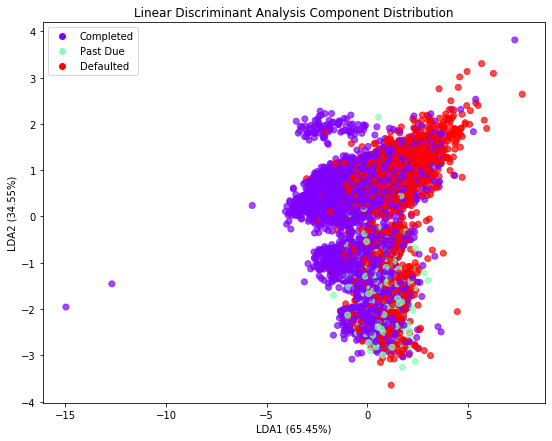

In [15]:
#Plot LDA Results
fig = plt.figure(figsize=[9,7])
plt.xlabel('LDA1 (%.2f%%)' % (lda.explained_variance_ratio_[0]*100))
plt.ylabel('LDA2 (%.2f%%)' % (lda.explained_variance_ratio_[1]*100)) 

scatter = plt.scatter(
    X_lda[:,0],
    X_lda[:,1],
    c=y_train,
    cmap='rainbow',
    alpha=0.7);

labels = np.unique(y)
handles = [plt.Line2D([],[],marker="o", ls="", 
                      color=scatter.cmap(scatter.norm(yi))) for yi in labels]
label = ['Completed','Past Due','Defaulted']
plt.legend(handles, label);

plt.title('Linear Discriminant Analysis Component Distribution');

#### SVM Algorithm

In [16]:
#SVM Model and Resulting Confusion Matrix and Accuracy Score
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import svm

#Train/Test Set using components from LDA
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_lda, y_train, test_size = 0.3)

#SVM Model
t0 = time()
clf_svm = svm.SVC(kernel = 'rbf', gamma='scale', decision_function_shape='ovo')
clf_svm.fit(X_train1, y_train1)

#Confusion Matrix (1 instance)
y_pred_svm = clf_svm.predict(X_test1)
print("SVM Training Time:", round(time()-t0, 1), "s \n")
print(confusion_matrix(y_test1, y_pred_svm),'\n')

#Cross Validation Score
kfold = model_selection.KFold(n_splits=4)
results_kfold = model_selection.cross_val_score(clf_svm, X_train1, y_train1, cv=kfold)
print("Accuracy: %.2f%%" % (results_kfold.mean()*100.0))

SVM Training Time: 21.1 s 

[[6194    0  255]
 [ 367    0    8]
 [2239    0  467]] 

Accuracy: 70.48%


<a id='Random Forest'></a>
### Model 2 - Random Forest

In [17]:
#Random Forest Algorithm
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(min_samples_split = 25, n_estimators = 100, criterion = 'entropy')
t0 = time()
clf_rf.fit(X_train, y_train)

#Confusion Matrix (1 instance)
y_pred_rf = clf_rf.predict(X_test)
print("RF Training Time:", round(time()-t0, 1), "s \n")
print(confusion_matrix(y_test, y_pred_rf),'\n')

#Cross Validation Score
kfold = model_selection.KFold(n_splits=4)
results_kfold = model_selection.cross_val_score(clf_rf, X_train, y_train, cv=kfold)
print("Accuracy: %.2f%%" % (results_kfold.mean()*100.0))

RF Training Time: 7.1 s 

[[8735    0  573]
 [ 495    0   40]
 [2776    0  995]] 

Accuracy: 71.17%


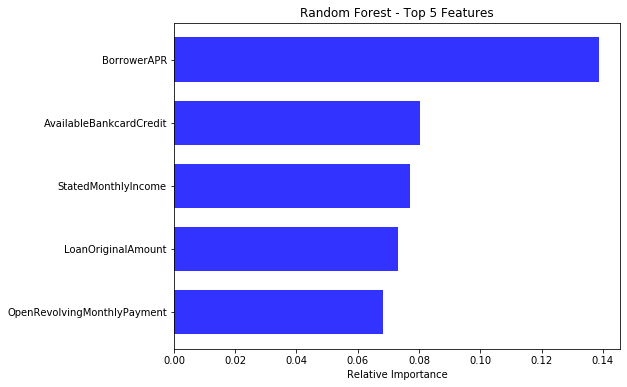

In [18]:
#Rank Features and transform to Dataframe - Output Top 5
feature_rank = pd.DataFrame(clf_rf.feature_importances_, index = X_train.columns,
                                    columns=['Importance']).sort_values('Importance', ascending=False).reset_index()
feature_rank.index = feature_rank.index + 1
feature_rank = feature_rank.rename(columns={"index": "Feature"})

fig = plt.figure(figsize=[8,6])
plt.barh(feature_rank['Feature'].head(5).sort_index(ascending = False).reset_index(drop=True)
         ,feature_rank['Importance'].head(5).sort_values(ascending=True)
         , color='b', align='center',alpha = 0.8, height = .7)
plt.title('Random Forest - Top 5 Features')
plt.xlabel('Relative Importance');

<a id='Regression'></a>
### Model 3 - Regression Model to Estimate Losses (Risk Assessment)

#### Mapping RF Predictions to Current Loans

In [19]:
#Duplicate features used in model onto new dataframe with just current loans

#Filter all Current Loans
current_loans = df1[df1['LoanStatus'] == 'Current']

#List of columns from original dataset during pre-processing stage
column_list = columns_df.tolist()

#New feature dataframe with filtered columns
df_current = current_loans[np.intersect1d(current_loans.columns, column_list)]

#Same pre-processing steps to match feature set used in model
df_current = dummies(df_current, 'EmploymentStatus')
df_current = dummies(df_current, 'Term')
df_current['c_Not employed'] = 0 #Current Loans did not have any unemployed borrowers so added in vector of 0's
df_current = df_current.drop(col_list, axis=1)
df_current = df_current.drop(deleted_columns, axis=1)

In [20]:
#Predict Loan Outcome for Current Loans using Random Forest model
y_pred_rf_current = clf_rf.predict(df_current)
current_loans['LoanStatus_pred'] = y_pred_rf_current

#### Regression Model - Estimate Gross Principal Loss of Current Loans Predicted to be Default

In [21]:
#Setup Dataframe for Regression Model Comprised of all Defaulted/Chargedoff
df_PL = df1.query('LP_GrossPrincipalLoss > 0 & LoanStatus == "Chargedoff" | LoanStatus == "Defaulted"')

#Same pre-processing steps to match feature set used in model
col_list2 = ['LoanStatus','ListingKey','LP_CustomerPayments','LP_CustomerPrincipalPayments']
df_PL = df_PL[np.intersect1d(df_PL.columns, column_list)]
df_PL = dummies(df_PL, 'EmploymentStatus')
df_PL = dummies(df_PL, 'Term')
df_PL = df_PL.drop(col_list2, axis=1)
df_PL = df_PL.drop(deleted_columns, axis=1)

#Feature/Label sets
y_PL = df_PL.query('LP_GrossPrincipalLoss > 0').LP_GrossPrincipalLoss
index_list = y_PL.index.tolist()
X_PL = df_PL[df_PL.index.isin(index_list)].loc[:, df_PL.columns != 'LP_GrossPrincipalLoss']

#Fit Regression Model & Output Evaluation Metrics (R^2 Score & MSE)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

reg = LinearRegression()
reg.fit(X_PL,y_PL)

print("R-Squared: %.2f%%" % (reg.score(X_PL, y_PL)*100.0))
print("Root Mean Squared Error:", round(np.sqrt(mean_squared_error(y_PL, reg.predict(X_PL))),2))

R-Squared: 83.41%
Root Mean Squared Error: 1837.41


In [22]:
#Filter all Defaulted Loans from RF Model
df_defaulted = current_loans.query('LoanStatus_pred == 2')

#Setup Dataframe to match feature set of RF Model
col_list2 = ['LoanStatus','ListingKey','LP_CustomerPayments','LP_CustomerPrincipalPayments']
df_defaulted = df_defaulted[np.intersect1d(df_defaulted.columns, column_list)]
df_defaulted = dummies(df_defaulted, 'EmploymentStatus')
df_defaulted = dummies(df_defaulted, 'Term')
df_defaulted['c_Not employed'] = 0 #Current Loans did not have any unemployed borrowers so added in vector of 0's
df_defaulted = df_defaulted.drop(col_list2, axis=1)
df_defaulted = df_defaulted.drop(deleted_columns, axis=1)

#Apply Regression Model to Predict (Estimate) Principal Loss
X_pred_PL = df_defaulted.loc[:, df_defaulted.columns != 'LP_GrossPrincipalLoss']
y_pred_PL = reg.predict(X_pred_PL)

df_defaulted['GrossPrincipalLoss_pred'] = y_pred_PL

<a id='Final'></a>
### Final Dataframe

In [23]:
#List of all Columns for Final Dataframe
final_col_list = ['ListingKey','Term','LoanStatus','LoanStatus_pred','BorrowerAPR','LenderYield','CreditScoreRangeLower',
                 'StatedMonthlyIncome','AvailableBankcardCredit','LoanOriginalAmount','MonthlyLoanPayment','DebtToIncomeRatio']
df_final = current_loans[final_col_list]

#Clean Dataframe
df_final['LoanStatus_pred'] = df_final['LoanStatus_pred'].replace({0:'Completed', 2: "Defaulted"})

#Add Predicted Losses Column
df_final = df_final.join(df_defaulted['GrossPrincipalLoss_pred'].to_frame())
df_final['GrossPrincipalLoss_pred'].fillna(0,inplace=True)

#Reorder Column
cols = df_final.columns.to_list()
cols.insert(4, cols.pop(cols.index('GrossPrincipalLoss_pred')))
df_final = df_final.reindex(columns= cols)
df_final

,ListingKey,Term,LoanStatus,LoanStatus_pred,GrossPrincipalLoss_pred,BorrowerAPR,LenderYield,CreditScoreRangeLower,StatedMonthlyIncome,AvailableBankcardCredit,LoanOriginalAmount,MonthlyLoanPayment,DebtToIncomeRatio
1,10273602499503308B223C1,36,Current,Completed,0.0,0.12016,0.0820,680.0,6125.000000,10266.0,10000,318.93,0.18
3,0EF5356002482715299901A,36,Current,Completed,0.0,0.12528,0.0874,800.0,2875.000000,30754.0,10000,321.45,0.15
4,0F023589499656230C5E3E2,36,Current,Completed,0.0,0.24614,0.1985,680.0,9583.333333,695.0,15000,563.97,0.26
5,0F05359734824199381F61D,60,Current,Completed,0.0,0.15425,0.1214,740.0,8333.333333,86509.0,15000,342.37,0.36
6,0F0A3576754255009D63151,36,Current,Completed,0.0,0.31032,0.2612,680.0,2083.333333,1929.0,3000,122.67,0.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...
113930,E35D3584034795373BCD69A,36,Current,Completed,0.0,0.20053,0.1539,680.0,6250.000000,1322.0,3000,106.05,0.20
113931,E36F36005339663245C20F8,60,Current,Completed,0.0,0.15016,0.1174,800.0,8146.666667,12056.0,25000,565.50,0.28
113932,E6D9357655724827169606C,36,Current,Completed,0.0,0.22354,0.1764,700.0,4333.333333,1886.0,10000,364.74,0.13
113934,E6E13596170052029692BB1,60,Current,Completed,0.0,0.23984,0.2050,700.0,2875.000000,7853.0,10000,273.35,0.51


In [24]:
df_final.to_csv('Credit Risk Modeling.csv')